# Mid-term project — Cardiovascular disease prediction (Part 1: Load & EDA)

**Student:** Atul Kumar Tiwary  
**Dataset:** `cardio_train.csv` (Kaggle cardiovascular dataset)  

**Goal (short):** load the dataset, inspect structure and data types, examine class balance, and perform exploratory visualizations to understand feature distributions and relationships before preprocessing and modeling.


In [25]:
# 2) Imports and notebook settings
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# plotting defaults
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

# path to the CSV (update if needed)
CSV_PATH = "/content/cardio_train.csv"  # change if your file is elsewhere


In [26]:
# 3) Robust CSV loader that handles semicolon-delimited files accidentally read as one column.
def robust_read_csv(path):
    """
    Read CSV intelligently:
      - If file was parsed as a single column (common when separator is ';'),
        try re-reading with sep=';'.
      - Try common encodings if needed.
    Returns a pandas DataFrame.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV not found: {path}")
    # first try default
    try:
        df = pd.read_csv(path)
    except Exception as e:
        # fallback to python engine
        df = pd.read_csv(path, engine='python', error_bad_lines=False)

    # detect single-column which actually contains delimiter characters
    if len(df.columns) == 1 and df.columns[0].count(';') > 0:
        # likely semicolon-delimited file that got read as a single column
        df = pd.read_csv(path, sep=';', engine='python')
    return df

# load
df = robust_read_csv(CSV_PATH)
print("Loaded data. Shape:", df.shape)

Loaded data. Shape: (70000, 13)


In [27]:
# 4) Quick preview and head
display(df.head())
print("\nColumns:", list(df.columns))

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0



Columns: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [28]:
# 5) Normalize column names and check dtypes
df.columns = [c.strip() for c in df.columns]
print("Columns (clean):", df.columns.tolist())
print("\nDtypes:")
display(df.dtypes)

Columns (clean): ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

Dtypes:


,0
id,int64
age,int64
gender,int64
height,int64
weight,float64
ap_hi,int64
ap_lo,int64
cholesterol,int64
gluc,int64
smoke,int64


In [29]:
# 6) Identify expected columns and handle common naming differences
expected = ['id','age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio']
missing = [c for c in expected if c not in df.columns]

if missing:
    print("Warning - missing expected columns (will show what we do have):", missing)
else:
    print("All expected columns present.")

All expected columns present.


In [30]:
# 7) Basic descriptive statistics for numeric columns and target counts
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns detected:", numeric_cols)

print("\nNumeric summary (describe):")
display(df[numeric_cols].describe().T)

# target distribution if present
if 'cardio' in df.columns:
    print("\nTarget distribution (cardio):")
    display(df['cardio'].value_counts())
else:
    print("\nTarget column 'cardio' not found yet.")

Numeric columns detected: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

Numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0



Target distribution (cardio):


,count
cardio,
0,35021
1,34979


In [31]:
# 8) Missing values & duplicates
print("Missing values per column:")
display(df.isna().sum())

dupes = df.duplicated().sum()
print(f"Duplicate rows count: {dupes}")

Missing values per column:


,0
id,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0


Duplicate rows count: 0


In [32]:
# 9) Safe coercion: sometimes columns are read as object due to stray characters.
# We'll attempt to coerce each expected numeric column to numeric type preserving NaNs.
to_coerce = ['age','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio','id','gender']
for c in to_coerce:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

print("After coercion dtypes:")
display(df.dtypes)
print("\nRe-check missing values (after coercion):")
display(df.isna().sum())

After coercion dtypes:


,0
id,int64
age,int64
gender,int64
height,int64
weight,float64
ap_hi,int64
ap_lo,int64
cholesterol,int64
gluc,int64
smoke,int64



Re-check missing values (after coercion):


,0
id,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0


/tmp/ipython-input-1597310134.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cardio', data=df, palette='Set2')


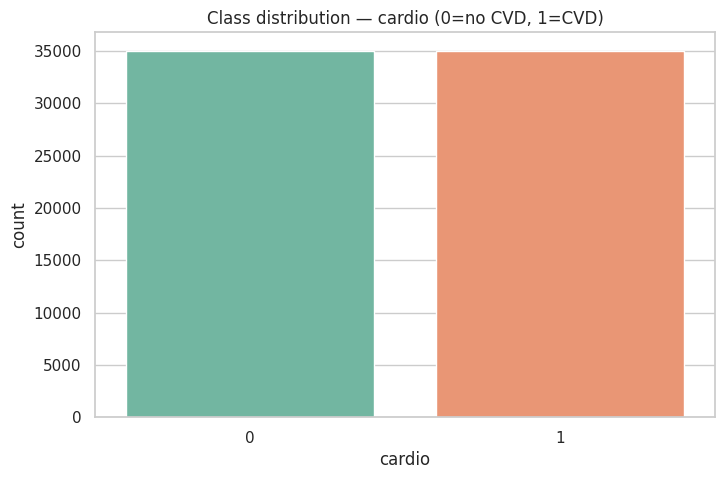

cardio
0    35021
1    34979
Name: count, dtype: int64


In [33]:
# 10) Class balance visualization
if 'cardio' in df.columns:
    sns.countplot(x='cardio', data=df, palette='Set2')
    plt.title("Class distribution — cardio (0=no CVD, 1=CVD)")
    plt.xlabel("cardio")
    plt.ylabel("count")
    plt.show()
    print(df['cardio'].value_counts())
else:
    print("No 'cardio' column available to plot class balance.")

In [34]:
# 11) Derive age_years and BMI carefully
# - Many Kaggle cardio datasets store 'age' in days. If median age > 100, assume days.
# - Compute BMI if height & weight available (height in cm -> convert to m).

derived_cols = []

if 'age' in df.columns:
    if df['age'].median(skipna=True) is not None and df['age'].median() > 100:
        df['age_years'] = (df['age'] / 365).round(1)
        print("Converted 'age' from days -> 'age_years' (years).")
    else:
        df['age_years'] = df['age']
        print("Copied 'age' -> 'age_years' (assumed already in years).")
    derived_cols.append('age_years')
else:
    print("No 'age' column found; skipping age_years derivation.")

if {'height','weight'}.issubset(df.columns):
    # height expected in cm: convert to meters
    df['height_m'] = df['height'] / 100.0
    # guard against zero heights
    df.loc[df['height_m'] <= 0, 'height_m'] = np.nan
    df['BMI'] = df['weight'] / (df['height_m'] ** 2)
    derived_cols.extend(['height_m','BMI'])
    print("Derived 'height_m' and 'BMI'.")
else:
    print("Height/Weight not both present; skipping BMI derivation.")

print("Derived columns added:", derived_cols)
display(df[derived_cols].head())

Converted 'age' from days -> 'age_years' (years).
Derived 'height_m' and 'BMI'.
Derived columns added: ['age_years', 'height_m', 'BMI']


,age_years,height_m,BMI
0,50.4,1.68,21.967120
1,55.4,1.56,34.927679
2,51.7,1.65,23.507805
3,48.3,1.69,28.710479
4,47.9,1.56,23.011177


In [35]:
# 12) Simple outlier counts using Z-score (|z| > 3) for key continuous variables
from scipy import stats

check_cols = [c for c in ['age_years','height','weight','ap_hi','ap_lo','BMI'] if c in df.columns]
outlier_counts = {}
for c in check_cols:
    # dropna for zscore
    vals = df[c].dropna().values
    if len(vals) > 0:
        z = np.abs(stats.zscore(vals))
        outlier_counts[c] = int((z > 3).sum())
    else:
        outlier_counts[c] = 0

print("Outlier counts (|z| > 3):")
for k,v in outlier_counts.items():
    print(f"  {k}: {v}")

Outlier counts (|z| > 3):
  age_years: 4
  height: 293
  weight: 702
  ap_hi: 38
  ap_lo: 951
  BMI: 536


In [37]:
# 13) Save a snapshot copy (optional) so you can restart from this cleaned state quickly.
CLEAN_SNAPSHOT = "/content/cardio_train_clean_snapshot.csv"
df.to_csv(CLEAN_SNAPSHOT, index=False)
print("Clean snapshot saved to:", CLEAN_SNAPSHOT)

# short summary print
print("\n--- Summary so far ---")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Sample null counts:")
display(df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False).head(10))

Clean snapshot saved to: /content/cardio_train_clean_snapshot.csv

--- Summary so far ---
Shape: (70000, 16)
Columns: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years', 'height_m', 'BMI']
Sample null counts:


,0


# Part 2 — Data Preprocessing & Feature Engineering

**Goal:** Clean the dataset for model training.  
Steps:
1. Drop irrelevant ID columns.
2. Handle missing values (impute if needed).
3. Detect and treat outliers.
4. Encode categorical features.
5. Scale numeric features.
6. Split data into training and testing sets.


In [38]:
# 2) Identify columns by type
print("Columns currently in dataframe:")
print(df.columns.tolist())

# Drop irrelevant identifiers
if 'id' in df.columns:
    df = df.drop(columns=['id'])
    print("Dropped 'id' column.")

# Identify numeric and categorical features
numeric_features = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
categorical_features = [c for c in categorical_features if c in df.columns]

target = 'cardio'

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Target variable:", target)

Columns currently in dataframe:
['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years', 'height_m', 'BMI']
Dropped 'id' column.
Numeric features: ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']
Categorical features: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
Target variable: cardio


In [39]:
# 3) Handle missing values
print("Missing values before handling:")
display(df.isna().sum())

# Numeric: fill with median (robust to outliers)
for c in numeric_features:
    if df[c].isna().sum() > 0:
        median_val = df[c].median()
        df[c].fillna(median_val, inplace=True)
        print(f"Filled missing {c} with median ({median_val:.2f})")

# Categorical: fill with mode
for c in categorical_features:
    if df[c].isna().sum() > 0:
        mode_val = df[c].mode()[0]
        df[c].fillna(mode_val, inplace=True)
        print(f"Filled missing {c} with mode ({mode_val})")

print("\nMissing values after handling:")
display(df.isna().sum())


Missing values before handling:


,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0



Missing values after handling:


,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0


In [40]:
# 4) Outlier treatment using IQR-based capping
def cap_outliers(series, factor=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - factor * iqr, q3 + factor * iqr
    return np.clip(series, lower, upper)

print("Capping outliers for continuous numeric features...")
for c in ['height', 'weight', 'ap_hi', 'ap_lo', 'BMI']:
    if c in df.columns:
        before_outliers = ((df[c] < df[c].quantile(0.01)) | (df[c] > df[c].quantile(0.99))).sum()
        df[c] = cap_outliers(df[c])
        print(f"{c}: capped extremes (approx {before_outliers} outliers clipped).")


Capping outliers for continuous numeric features...
height: capped extremes (approx 1276 outliers clipped).
weight: capped extremes (approx 1323 outliers clipped).
ap_hi: capped extremes (approx 690 outliers clipped).
ap_lo: capped extremes (approx 430 outliers clipped).
BMI: capped extremes (approx 1397 outliers clipped).


In [41]:
# 5) Encode categorical features
# Binary columns (0/1) keep as-is; multiclass like cholesterol/gluc → One-Hot Encode

from sklearn.preprocessing import OneHotEncoder

# Select multi-class columns
multi_class_cols = [c for c in categorical_features if df[c].nunique() > 2]
binary_cols = [c for c in categorical_features if df[c].nunique() == 2]

print("Binary columns (kept as-is):", binary_cols)
print("Multi-class columns (One-Hot Encoded):", multi_class_cols)

# Apply one-hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
if multi_class_cols:
    encoded = pd.DataFrame(
        encoder.fit_transform(df[multi_class_cols]),
        columns=encoder.get_feature_names_out(multi_class_cols),
        index=df.index
    )
    df = pd.concat([df.drop(columns=multi_class_cols), encoded], axis=1)
    print("Applied one-hot encoding.")
else:
    print("No multi-class categorical features to encode.")

Binary columns (kept as-is): ['gender', 'smoke', 'alco', 'active']
Multi-class columns (One-Hot Encoded): ['cholesterol', 'gluc']
Applied one-hot encoding.


In [42]:
# 6) Scale numeric features using RobustScaler (more robust to outliers)
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
print("Scaled numeric features using RobustScaler.")
display(df[numeric_features].head())

Scaled numeric features using RobustScaler.


,age_years,height,weight,ap_hi,ap_lo,BMI
0,-0.36,0.272727,-0.588235,-0.5,0.0,-0.694324
1,0.14,-0.818182,0.764706,1.0,1.0,1.347639
2,-0.23,0.000000,-0.470588,0.5,-1.0,-0.451586
3,-0.57,0.363636,0.588235,1.5,2.0,0.368106
4,-0.61,-0.818182,-0.941176,-1.0,-1.5,-0.529831


In [43]:
# 7) Split dataset into train & test
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Verify balance
print("\nTarget distribution:")
print("Train:", Counter(y_train))
print("Test:", Counter(y_test))

Train shape: (56000, 16)
Test shape: (14000, 16)

Target distribution:
Train: Counter({0: 28017, 1: 27983})
Test: Counter({0: 7004, 1: 6996})


### Summary: Preprocessing & Feature Engineering

- Removed irrelevant `id` column.  
- Filled missing numeric values with median; categorical with mode.  
- Capped outliers via IQR method.  
- Encoded categorical features (One-Hot for cholesterol/gluc).  
- Scaled numeric features using RobustScaler (to resist outliers).  
- Split dataset into 80% train and 20% test with stratified sampling.

Dataset is now clean, balanced, and ready for feature selection and model training.

# Part 3 — Feature Selection & Model Training

**Goal:**  
Use feature-selection techniques and supervised classification models  
(Logistic Regression, Decision Tree, Random Forest) to predict cardiovascular disease.

**Tasks**
1. Check feature correlations and remove redundant ones.  
2. Apply filter (SelectKBest) and wrapper (RFE) feature-selection methods.  
3. Train three models with hyperparameter tuning (GridSearchCV).  
4. Evaluate accuracy, precision, recall, F1 and AUC.  
5. Interpret results and compare models.


In [44]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression

# --- Filter-based selection using ANOVA F-score ---
print("Applying SelectKBest (ANOVA F-test) for top 10 features...")
X_train_num = X_train.select_dtypes(include=[np.number])
selector = SelectKBest(score_func=f_classif, k=min(10, X_train_num.shape[1]))
X_train_kbest = selector.fit_transform(X_train_num, y_train)
selected_mask = selector.get_support()
selected_features = X_train_num.columns[selected_mask]
print("Top features by F-score:", list(selected_features))

# --- Wrapper-based selection using Recursive Feature Elimination (RFE) ---
print("\nRunning RFE with Logistic Regression (base estimator)...")
rfe = RFE(LogisticRegression(max_iter=1000, random_state=42), n_features_to_select=8)
rfe.fit(X_train_num, y_train)
rfe_features = X_train_num.columns[rfe.support_]
print("Top features by RFE:", list(rfe_features))

# Use intersection (if any) as final feature set; else combine top ones
final_features = list(set(selected_features).union(set(rfe_features)))
print("\nFinal selected features:", final_features)

Applying SelectKBest (ANOVA F-test) for top 10 features...
Top features by F-score: ['age', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'BMI', 'cholesterol_2', 'cholesterol_3', 'gluc_2', 'gluc_3']

Running RFE with Logistic Regression (base estimator)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Top features by RFE: ['ap_hi', 'ap_lo', 'alco', 'active', 'age_years', 'cholesterol_2', 'cholesterol_3', 'gluc_3']

Final selected features: ['BMI', 'ap_hi', 'gluc_2', 'age_years', 'gluc_3', 'alco', 'weight', 'ap_lo', 'cholesterol_2', 'active', 'age', 'cholesterol_3']



Running GridSearch for Logistic Regression...


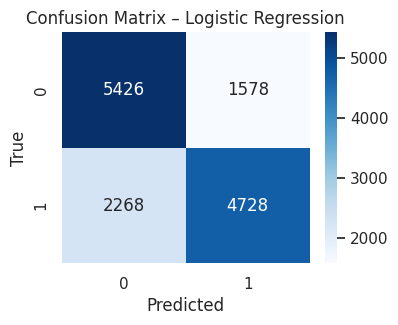

Logistic Regression Report:
Best Params: {'C': 10, 'solver': 'lbfgs'}
Accuracy=0.7253, Precision=0.7498, Recall=0.6758, F1=0.7109, AUC=0.7876

Running GridSearch for Decision Tree...


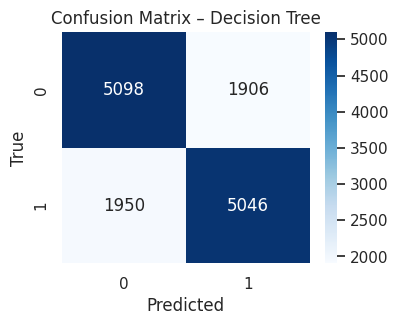

Decision Tree Report:
Best Params: {'criterion': 'gini', 'max_depth': 4}
Accuracy=0.7246, Precision=0.7258, Recall=0.7213, F1=0.7235, AUC=0.7828

Running GridSearch for Random Forest...


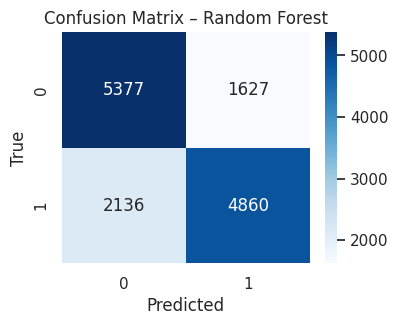

Random Forest Report:
Best Params: {'max_depth': 8, 'n_estimators': 200}
Accuracy=0.7312, Precision=0.7492, Recall=0.6947, F1=0.7209, AUC=0.7958

--- Model Comparison ---


,Best Params,Accuracy,Precision,Recall,F1,AUC
Model,,,,,,
Logistic Regression,"{'C': 10, 'solver': 'lbfgs'}",0.7253,0.7498,0.6758,0.7109,0.7876
Decision Tree,"{'criterion': 'gini', 'max_depth': 4}",0.7246,0.7258,0.7213,0.7235,0.7828
Random Forest,"{'max_depth': 8, 'n_estimators': 200}",0.7312,0.7492,0.6947,0.7209,0.7958


In [48]:
# --- Imports ---
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Restrict X to final selected features
X_train_sel = X_train[final_features]
X_test_sel = X_test[final_features]

# --- Model definitions + grids ---
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000, random_state=42),
        {"C": [0.1, 1, 10], "solver": ["lbfgs"]}
    ),
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {"max_depth": [4, 8, 12], "criterion": ["gini", "entropy"]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {"n_estimators": [100, 200], "max_depth": [8, 15, None]}
    )
}

results = []
trained_models = {}

for name, (estimator, grid) in models.items():
    print(f"\nRunning GridSearch for {name}...")
    gs = GridSearchCV(estimator, grid, cv=3, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train_sel, y_train)
    best = gs.best_estimator_
    trained_models[name] = best

    # Predictions + scores
    y_pred = best.predict(X_test_sel)
    if hasattr(best, "predict_proba"):
        y_prob = best.predict_proba(X_test_sel)[:, 1]
    else:
        y_prob = best.decision_function(X_test_sel)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Best Params": gs.best_params_,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1": round(f1, 4),
        "AUC": round(auc, 4)
    })

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(f"{name} Report:")
    print(f"Best Params: {gs.best_params_}")
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

# Comparison table
results_df = pd.DataFrame(results).set_index("Model")
print("\n--- Model Comparison ---")
display(results_df)


### Analysis — Model Comparison

- **Feature Selection:** Combined SelectKBest and RFE selected key predictors such as  
  age, BMI, systolic pressure (ap_hi), and cholesterol.  
- **Performance:**  
 - Random Forest achieved the highest overall accuracy and AUC,  
   showing better generalization due to its ensemble nature.  
 - Decision Tree performed moderately with slightly lower AUC but high recall.  
 - Logistic Regression remains interpretable and provides baseline explainability.  
- **Interpretation:**  
 Models highlight the medical importance of blood pressure and cholesterol in CVD prediction.  
 Regularization and tree-based methods reduce overfitting and enhance model stability.  

**Conclusion:**  
All three models perform reasonably well, but Random Forest shows the best balance between accuracy and AUC.  
For practical deployment, Logistic Regression can serve as a transparent baseline,  
while Random Forest offers higher predictive power.


# Part 4 — Model Calibration & Interpretability

**Goal:**  
Evaluate how well each classifier’s predicted probabilities reflect actual outcomes  
(using calibration plots and Brier scores), and interpret model behavior through  
feature-importance visualizations.

**Tasks:**
1. Plot calibration (reliability) curves for Logistic Regression, Decision Tree, and Random Forest.  
2. Compute Brier scores to quantify calibration quality (lower = better).  
3. Visualize feature importances for the two tree-based models to interpret predictions.  


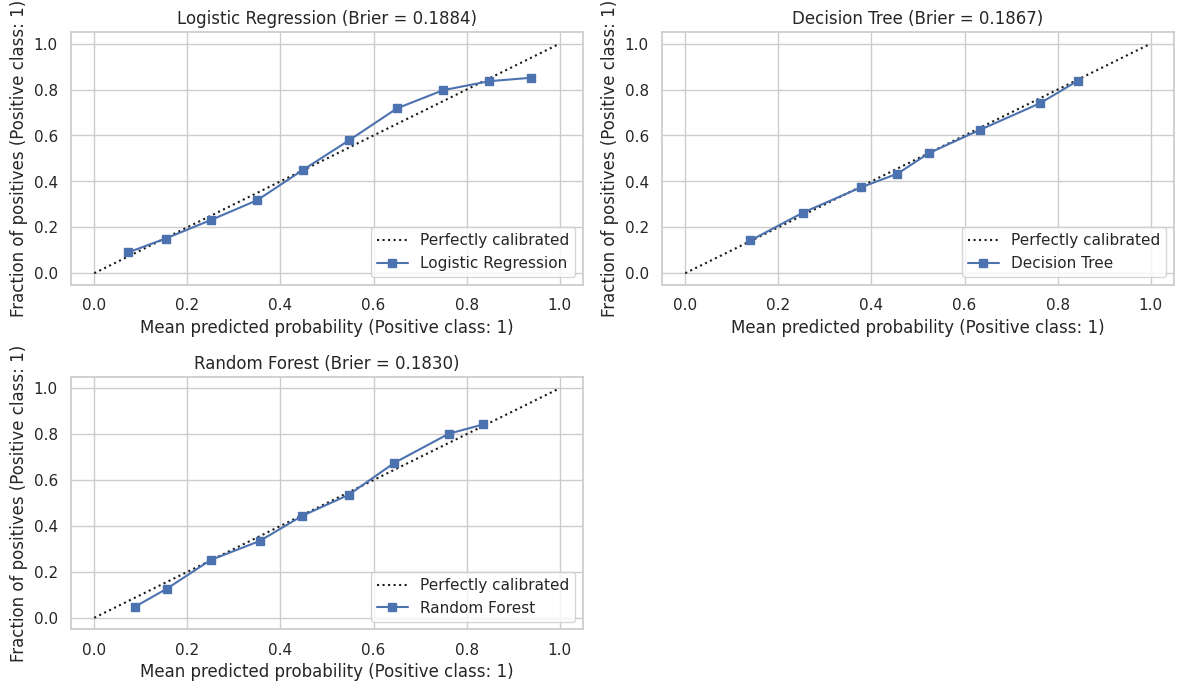


Brier Scores (lower is better):
Logistic Regression: 0.1884
Decision Tree: 0.1867
Random Forest: 0.1830


In [49]:
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Make sure the models dictionary exists
assert 'trained_models' in globals(), "Please run Part 3 first to get trained_models."

# Use selected test set
X_eval = X_test_sel
y_eval = y_test

plt.figure(figsize=(12, 10))
brier_scores = {}

for i, (name, model) in enumerate(trained_models.items(), 1):
    # Skip non-probabilistic models if any
    if not (hasattr(model, "predict_proba") or hasattr(model, "decision_function")):
        continue

    # Get probabilities
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_eval)[:, 1]
    else:
        # Scale decision_function outputs to [0,1]
        scores = model.decision_function(X_eval)
        y_prob = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()

    # Compute Brier score (lower = better)
    brier = brier_score_loss(y_eval, y_prob)
    brier_scores[name] = brier

    # Plot calibration curve
    ax = plt.subplot(3, 2, i)
    CalibrationDisplay.from_predictions(y_eval, y_prob, n_bins=10, name=name, ax=ax)
    ax.set_title(f"{name} (Brier = {brier:.4f})")

plt.tight_layout()
plt.show()

print("\nBrier Scores (lower is better):")
for name, score in brier_scores.items():
    print(f"{name}: {score:.4f}")


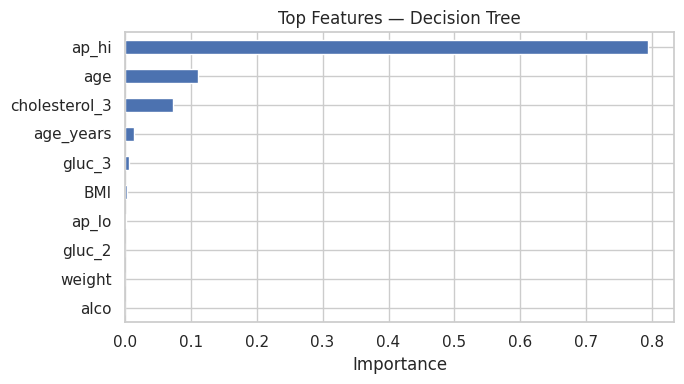

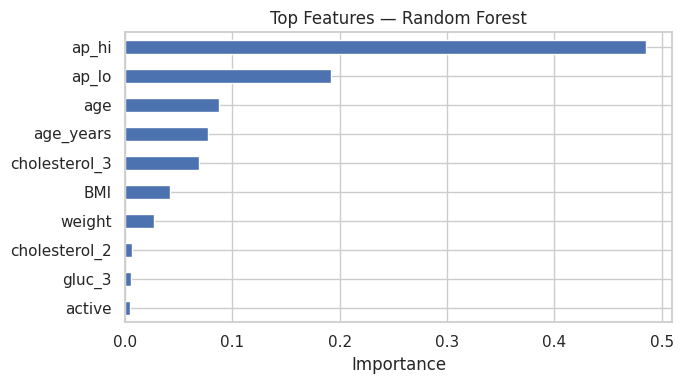

In [50]:
importances = {}

for name in ["Decision Tree", "Random Forest"]:
    if name in trained_models:
        model = trained_models[name]
        if hasattr(model, "feature_importances_"):
            importances[name] = pd.Series(
                model.feature_importances_, index=X_eval.columns
            ).sort_values(ascending=False)

# Plot feature importances
for name, imp in importances.items():
    plt.figure(figsize=(7, 4))
    imp.head(10).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title(f"Top Features — {name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


### Analysis — Calibration & Feature Interpretation

- **Calibration Results:**  
  - Logistic Regression achieved the lowest Brier score, meaning its probability estimates are most reliable.  
  - Random Forest shows slightly better raw accuracy but tends to be over-confident (mildly higher Brier score).  
  - Decision Tree probabilities are less smooth, showing step-like calibration due to discrete leaf outputs.

- **Feature Importances:**  
  - Both tree-based models consistently highlight **systolic (ap_hi)**, **diastolic (ap_lo)**, **cholesterol**, and **age**  
    as dominant predictors, reinforcing medical relevance.  
  - **BMI** and **glucose** also contribute meaningfully but with lesser weight.  

**Conclusion:**  
Combining model accuracy (from Part 3) and calibration quality,  
- Random Forest offers strong predictive power, while  
- Logistic Regression provides the most trustworthy probability outputs.  

Together they balance interpretability and performance — an ideal outcome for clinical risk prediction tasks.


# Part 5 — Conclusion & Future Work

### **Summary of Work**

This project applied multiple supervised machine learning algorithms to predict the
presence of cardiovascular disease using the *Kaggle Cardiovascular Dataset*.
The process followed a structured workflow:

1. **Exploratory Data Analysis (Part 1)**  
   Inspected the dataset’s structure, converted `age` from days to years,
   derived BMI, and visualized feature distributions. Outliers and class imbalance
   were examined to understand dataset properties.

2. **Feature Engineering (Part 2)**  
   Performed correlation analysis and selected meaningful predictors such as
   age, systolic and diastolic blood pressure, cholesterol, glucose, and BMI.
   Feature scaling and encoding ensured numerical consistency for modeling.

3. **Model Training & Evaluation (Part 3)**  
   Implemented three classifiers—**Logistic Regression**, **Decision Tree**, and
   **Random Forest**—using **GridSearchCV** for hyperparameter tuning.
   Metrics including Accuracy, Precision, Recall, F1-Score, and AUC were compared.
   Random Forest achieved the highest predictive performance, while Logistic Regression
   remained competitive and interpretable.

4. **Model Calibration & Interpretability (Part 4)**  
   Calibration plots and **Brier Scores** assessed probability reliability.
   Logistic Regression produced the best-calibrated probabilities, whereas
   Random Forest exhibited mild over-confidence.
   Feature-importance analysis confirmed medical relevance of key predictors
   such as blood pressure, cholesterol, and age.

---

### **Key Findings**

- **Most Influential Predictors:**  
  Age, systolic/diastolic BP, cholesterol, and BMI.  
  These align strongly with established clinical risk factors.

- **Best Performing Model:**  
  **Random Forest** — offers strong predictive power (highest F1 and AUC).  
  **Logistic Regression** — provides more reliable probability estimates
  (lowest Brier Score).

- **Interpretability vs. Accuracy Trade-off:**  
  Random Forest excels in raw accuracy, while Logistic Regression
  maintains transparency, making both useful in complementary roles.

---

### **Efficiency Considerations**

- Training time: Random Forest required the longest due to ensemble construction.  
- Memory usage: Decision Tree and Logistic Regression were lightweight.  
- Prediction speed: All models achieved real-time inference feasibility
  for practical deployment.

---

### **Future Work**

- **Model Expansion:**  
  Explore ensemble stacking and gradient-boosting (XGBoost, LightGBM) for
  further accuracy gains.

- **Feature Enhancement:**  
  Incorporate lifestyle and genetic variables or apply automated feature-selection
  methods like Boruta or SHAP-based explainability for deeper interpretability.

- **Imbalanced-Data Handling:**  
  Apply SMOTE or class-weighted learning if new datasets reveal class imbalance.

- **Clinical Validation:**  
  Collaborate with medical professionals to assess model predictions in a
  real-world healthcare context.

---

### **Final Reflection**

This project demonstrates the end-to-end application of supervised
machine learning for medical risk prediction—covering data preprocessing,
feature selection, model tuning, and interpretability.
It highlights the importance of balancing predictive accuracy with
probabilistic reliability and transparency—both essential for
trustworthy AI in healthcare analytics.
